In [30]:
import os
import glob
import sox
import tqdm
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

%matplotlib inline  

In [2]:
num_parallel = 16
datapath_root = '/home/tracek/Data/gender/raw/'
datapath_male = os.path.join(datapath_root, 'male/')
datapath_female = os.path.join(datapath_root, 'female/')

In [3]:
waves_male_paths = glob.glob(datapath_male + '/**/*.wav', recursive=True)
waves_female_paths = glob.glob(datapath_female + '/**/*.wav', recursive=True)
readme_paths = glob.glob(datapath_root + '/**/README', recursive=True)

In [4]:
assert len(os.listdir(datapath_male)) + len(os.listdir(datapath_female)) == len(readme_paths)

In [5]:
def get_info(path):
    info = sox.file_info.info(path)
    info['path'] = path
    if 'num_samples' not in info:
        print('No samples in ', path)
    return info

In [6]:
pool = Pool(processes=num_parallel)
male_info = pool.map(get_info, waves_male_paths)
female_info = pool.map(get_info, waves_female_paths)

In [7]:
def get_readme_info(path):
    d = {}
    with open(path, 'r') as readme:
        for line in readme:
            gender_match = re.search("Gender: (\W*\w+\W*)", line, re.IGNORECASE)
            age_match = re.search("Age Range: (\W*\w+\W*)", line, re.IGNORECASE)
            lang_match = re.search("Language: (\W*\w+\W*)", line, re.IGNORECASE)

In [8]:
duration_male = np.array([info['duration'] for info in male_info])
duration_female = np.array([info['duration'] for info in female_info])
total_male = int(duration_male.sum())
total_female = int(duration_female.sum())
print('Total duration of male recordings: {} '.format(str(timedelta(seconds=total_male))))
print('Total duration of female recordings: {} '.format(str(timedelta(seconds=total_female))))

Total duration of male recordings: 3 days, 15:03:21 
Total duration of female recordings: 15:32:04 


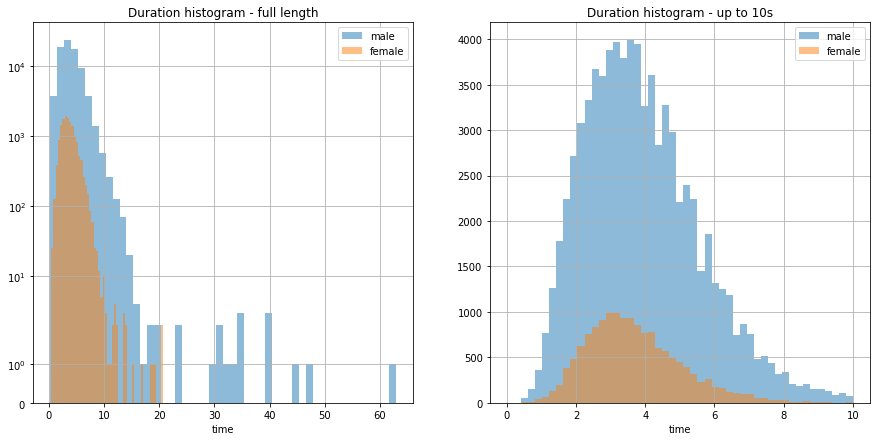

In [9]:
no_bins = 50
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].set_yscale('symlog')
_ = ax[0].hist(duration_male, bins=no_bins, alpha=0.5, label='male')
_ = ax[0].hist(duration_female, bins=no_bins, alpha=0.5, label='female')
bins = np.linspace(0, 10, no_bins)
_ = ax[1].hist(duration_male, bins=bins, alpha=0.5, label='male')
_ = ax[1].hist(duration_female, bins=bins, alpha=0.5, label='female')
ax[0].legend(loc='upper right')
ax[0].set_title('Duration histogram - full length')
ax[0].set_xlabel('time')
ax[0].grid(True)
ax[1].legend(loc='upper right')
ax[1].set_title('Duration histogram - up to 10s')
ax[1].set_xlabel('time')
ax[1].grid(True)

In [10]:
name_duration_tuples_m = [(info['path'], info['duration']) for info in male_info]
name_duration_tuples_m_short = [(info['path'], info['duration']) for info in male_info if info['duration'] < 0.5]

In [11]:
len(name_duration_tuples_m_short)

12

In [12]:
datapath = '/home/tracek/Data/gender/gender_warbler.csv'
data = pd.read_csv(datapath)
male_df = data[data['label'] == 0]
female_df = data[data['label'] == 1]
print('Male recordings: ', len(male_df))
print('Female recordings: ', len(female_df))
pd.set_option('display.max_columns', len(male_df.columns.values))
pd.set_option('display.max_rows', len(male_df))

male_stats = male_df.describe()
female_stats = female_df.describe()

male_corr = male_df.corr()
female_corr = female_df.corr()

Male recordings:  78820
Female recordings:  15066


In [13]:
male_stats

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
count,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.000000,78820.0
mean,0.158190,0.069968,0.155800,0.106229,0.217577,0.111348,5.315956,105.732651,0.913650,0.522978,0.113875,0.158190,0.111827,0.024538,0.238085,0.490626,0.046838,2.842126,2.795288,0.193379,0.0
std,0.029525,0.011912,0.040531,0.040964,0.030279,0.031203,7.640572,265.642245,0.056788,0.150907,0.082187,0.029525,0.021039,0.016960,0.040491,0.423132,0.080493,2.165304,2.149576,0.108625,0.0
min,0.000048,0.000924,0.000000,0.000000,0.000114,0.000114,0.096627,1.362474,0.081732,0.000029,0.000000,0.000048,0.016000,0.015640,0.016000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.142832,0.062430,0.129322,0.092997,0.205044,0.099816,1.817707,6.767020,0.899896,0.442717,0.049931,0.142832,0.098321,0.016194,0.219178,0.180060,0.000000,0.617188,0.585938,0.122613,0.0
50%,0.159605,0.070046,0.152600,0.111946,0.222386,0.112615,2.460985,10.636244,0.922687,0.542471,0.116667,0.159605,0.111734,0.017817,0.253968,0.397569,0.000000,3.070312,3.015625,0.183710,0.0
75%,0.177101,0.077571,0.183902,0.128866,0.237317,0.123661,3.532095,20.589989,0.940810,0.629068,0.166339,0.177101,0.123941,0.024206,0.271186,0.700120,0.085938,4.726562,4.664062,0.258026,0.0
max,0.260308,0.113707,0.270406,0.259467,0.276782,0.258316,51.242799,2774.534469,0.988251,0.907603,0.280000,0.260308,0.249851,0.197531,0.275862,4.855699,2.609375,6.992188,6.992188,1.000000,0.0


In [14]:
female_stats

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
count,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.000000,15066.0
mean,0.185398,0.051220,0.190744,0.158069,0.219492,0.061423,3.109131,34.942888,0.883406,0.360126,0.176823,0.185398,0.166105,0.030376,0.256262,0.667128,0.100262,3.885722,3.785460,0.200783,1.0
std,0.027135,0.016517,0.031762,0.044361,0.024374,0.039292,4.204126,138.466819,0.049327,0.144613,0.064844,0.027135,0.022139,0.025143,0.021417,0.410212,0.080838,2.275746,2.250809,0.091063,0.0
min,0.000050,0.001123,0.000000,0.000000,0.000121,0.000121,0.058957,1.706946,0.082314,0.000043,0.000000,0.000050,0.041972,0.015640,0.086957,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.177202,0.038919,0.181398,0.157535,0.204035,0.036971,1.711029,5.797064,0.861708,0.257301,0.170521,0.177202,0.156878,0.016789,0.246154,0.338033,0.000000,1.048828,1.015625,0.135274,1.0
50%,0.188914,0.047223,0.194186,0.170499,0.220898,0.050785,2.219656,8.370690,0.888449,0.320151,0.188432,0.188914,0.169095,0.020000,0.262295,0.618518,0.148438,4.835938,4.695312,0.191833,1.0
75%,0.202092,0.059854,0.208257,0.181184,0.236503,0.068883,2.912152,12.897301,0.911048,0.447784,0.211336,0.202092,0.179428,0.031311,0.271186,0.924594,0.164062,5.703125,5.585938,0.256827,1.0
max,0.252869,0.123865,0.270012,0.253907,0.276212,0.258962,46.825122,2308.549017,0.979994,0.855575,0.280000,0.252869,0.257717,0.225352,0.275862,2.927557,1.210938,6.992188,6.992188,1.000000,1.0


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
meanfreq,1.000000,-0.531370,0.918285,0.908345,0.830313,-0.386770,-0.457958,-0.417237,0.159927,-0.499641,0.655460,1.000000,0.309700,0.120628,-0.113266,0.414225,0.449952,0.350724,0.336441,0.281725,NaN
sd,-0.531370,1.000000,-0.441099,-0.682203,-0.086575,0.811592,0.410973,0.388134,0.243810,0.642498,-0.522495,-0.531370,-0.127773,-0.057107,0.111296,-0.284795,-0.365445,-0.286867,-0.275282,-0.177614,NaN
median,0.918285,-0.441099,1.000000,0.772453,0.711091,-0.324061,-0.342813,-0.301344,0.147395,-0.407684,0.601589,0.918285,0.225871,0.042936,-0.055700,0.394752,0.423723,0.304268,0.290627,0.219111,NaN
Q25,0.908345,-0.682203,0.772453,1.000000,0.653534,-0.678638,-0.499486,-0.469299,0.075059,-0.512691,0.635642,0.908345,0.337124,0.150121,-0.125235,0.371944,0.423727,0.328561,0.315098,0.296324,NaN
Q75,0.830313,-0.086575,0.711091,0.653534,1.000000,0.112408,-0.337403,-0.303856,0.265974,-0.244582,0.456325,0.830313,0.260794,0.154114,-0.114132,0.292881,0.287644,0.246390,0.237422,0.248244,NaN
IQR,-0.386770,0.811592,-0.324061,-0.678638,0.112408,1.000000,0.328323,0.321247,0.159556,0.435730,-0.391672,-0.386770,-0.189511,-0.047532,0.053659,-0.204088,-0.277151,-0.192247,-0.183275,-0.148128,NaN
skew,-0.457958,0.410973,-0.342813,-0.499486,-0.337403,0.328323,1.000000,0.978248,-0.423898,0.008372,-0.526812,-0.457958,-0.272721,-0.158513,0.146785,-0.397926,-0.208972,-0.438794,-0.434180,-0.484166,NaN
kurt,-0.417237,0.388134,-0.301344,-0.469299,-0.303856,0.321247,0.978248,1.000000,-0.397813,0.008904,-0.476433,-0.417237,-0.251485,-0.157671,0.150416,-0.367938,-0.194626,-0.403165,-0.398827,-0.471864,NaN
sp.ent,0.159927,0.243810,0.147395,0.075059,0.265974,0.159556,-0.423898,-0.397813,1.000000,0.590999,0.050762,0.159927,0.060196,-0.065375,0.068242,0.121628,-0.091384,0.177869,0.182592,0.186912,NaN
sfm,-0.499641,0.642498,-0.407684,-0.512691,-0.244582,0.435730,0.008372,0.008904,0.590999,1.000000,-0.341765,-0.499641,-0.183386,-0.100184,0.096793,-0.132090,-0.327100,-0.105780,-0.094306,0.000530,NaN


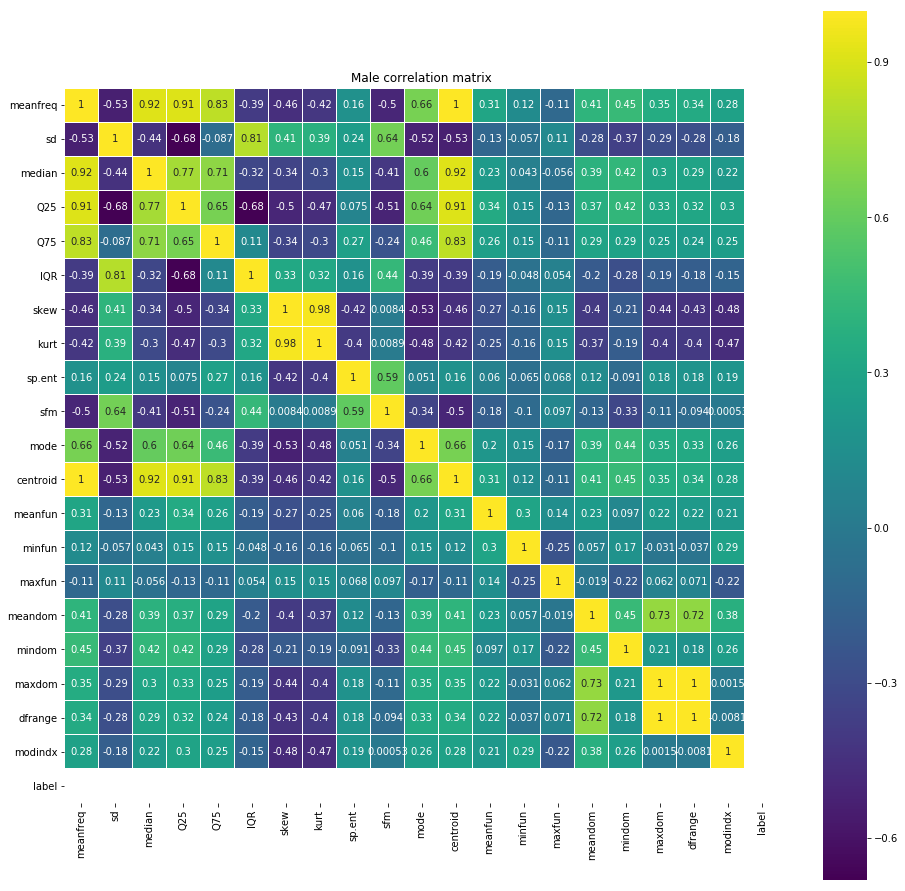

In [22]:
plt.figure(figsize=(16, 16))
plt.title('Male correlation matrix')

sns.heatmap(male_corr, 
            xticklabels=male_corr.columns.values,
            yticklabels=male_corr.columns.values,
            linewidths=0.2,
            vmax=1.0,
            square=True,
            cmap=plt.cm.viridis,
            linecolor='white',
            annot=True)

male_corr

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
meanfreq,1.000000,-0.591699,0.918497,0.902134,0.756762,-0.549060,-0.432546,-0.393026,-0.031598,-0.603696,0.692733,1.000000,0.377440,0.022280,0.139019,0.292911,0.449077,0.282852,0.269858,0.102016,NaN
sd,-0.591699,1.000000,-0.360005,-0.741397,0.010176,0.843342,0.413481,0.414254,0.444014,0.791996,-0.508388,-0.591699,-0.226911,-0.114754,0.241278,-0.292050,-0.569494,-0.390213,-0.374083,-0.050739,NaN
median,0.918497,-0.360005,1.000000,0.769501,0.779386,-0.385284,-0.302692,-0.265863,0.023799,-0.438997,0.628579,0.918497,0.357200,0.012623,0.176223,0.220147,0.304623,0.184843,0.175950,0.080306,NaN
Q25,0.902134,-0.741397,0.769501,1.000000,0.470786,-0.836948,-0.507232,-0.490065,-0.163741,-0.626415,0.696789,0.902134,0.407962,0.109540,-0.021341,0.305391,0.453366,0.307263,0.294385,0.131133,NaN
Q75,0.756762,0.010176,0.779386,0.470786,1.000000,0.088815,-0.213375,-0.150340,0.316771,-0.169233,0.437554,0.756762,0.237149,-0.109853,0.396178,0.129861,0.154398,0.061192,0.056324,0.064652,NaN
IQR,-0.549060,0.843342,-0.385284,-0.836948,0.088815,1.000000,0.440297,0.460018,0.381363,0.602237,-0.515241,-0.549060,-0.313474,-0.191814,0.269854,-0.264227,-0.416068,-0.308938,-0.297418,-0.107942,NaN
skew,-0.432546,0.413481,-0.302692,-0.507232,-0.213375,0.440297,1.000000,0.973781,-0.389195,0.055770,-0.546284,-0.432546,-0.217733,-0.072983,0.035086,-0.316585,-0.246191,-0.300883,-0.295374,-0.341491,NaN
kurt,-0.393026,0.414254,-0.265863,-0.490065,-0.150340,0.460018,0.973781,1.000000,-0.337551,0.071647,-0.499239,-0.393026,-0.218243,-0.091520,0.085665,-0.285158,-0.228461,-0.286103,-0.281068,-0.319344,NaN
sp.ent,-0.031598,0.444014,0.023799,-0.163741,0.316771,0.381363,-0.389195,-0.337551,1.000000,0.669291,-0.003498,-0.031598,-0.127057,-0.161566,0.279201,0.056906,-0.229515,-0.029763,-0.021849,0.201129,NaN
sfm,-0.603696,0.791996,-0.438997,-0.626415,-0.169233,0.602237,0.055770,0.071647,0.669291,1.000000,-0.357639,-0.603696,-0.288747,-0.088524,0.121086,-0.129590,-0.493119,-0.245365,-0.230373,0.121188,NaN


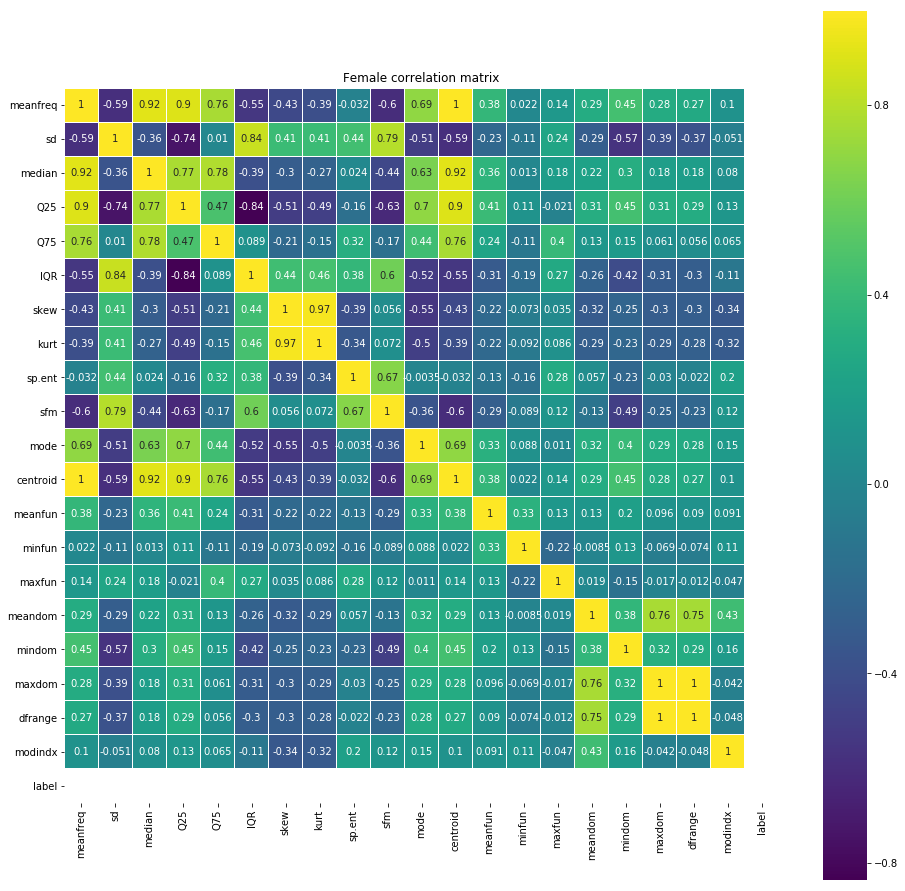

In [23]:
plt.figure(figsize=(16, 16))
plt.title('Female correlation matrix')

sns.heatmap(female_corr, 
            xticklabels=female_corr.columns.values,
            yticklabels=female_corr.columns.values,
            linewidths=0.2,
            vmax=1.0,
            square=True,
            cmap=plt.cm.viridis,
            linecolor='white',
            annot=True)

female_corr

In [24]:
# Let's make sure types are OK
data.dtypes

filename     object
meanfreq    float64
sd          float64
median      float64
Q25         float64
Q75         float64
IQR         float64
skew        float64
kurt        float64
sp.ent      float64
sfm         float64
mode        float64
centroid    float64
meanfun     float64
minfun      float64
maxfun      float64
meandom     float64
mindom      float64
maxdom      float64
dfrange     float64
modindx     float64
label         int64
dtype: object

In [28]:
y = data.pop('label')
data = data.drop(['centroid', 'dfrange', 'filename'], axis=1)
X = StandardScaler().fit_transform(data)

In [ ]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
X = tsne.fit_transform(X)

In [ ]:
plt.scatter(X[np.where(y == 0), 0],
            X[np.where(y == 0), 1],
            marker='x', color='b',
            linewidth='1', alpha=0.7, label='Male')
plt.scatter(X[np.where(y == 1), 0],
            X[np.where(y == 1), 1],
            marker='x', color='r',
            linewidth='1', alpha=0.7, label='Female')